# Classification of power spectra with BaCoN

This notebook shows how to classify a dark matter power spectrum using the pre-trained BaCoN model. It can be used to classify any new spectrum. See the data description for the format required

## Load the code

Here we mount the drive and import BaCoN. If running on your machine, be sure to have tensorflow2 and tensorflow probability installed and jump directly to the imports.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Work/Bacon/BaCoN-II/

/content/drive/MyDrive/Work/Bacon/BaCoN-II


In [ ]:
import os; #os.chdir('/content/drive/MyDrive/BaCoN-master/')
import numpy as np
import subprocess
import argparse
from test import *
from utils import *
from models import *
from data_generator import *
from train import *
from importer import load_model_for_test, my_predict, predict_bayes_label, predict_mean_proba
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'serif'
plt.rcParams["mathtext.fontset"] = "cm"

## Training a new network
If you want to load a pre-trained network, like the default BaCoN-II network, skip ahead to the next sections.


In [ ]:
!pip install -q lib5c
!lib5c -v

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
lib5c version 0.6.1


In [ ]:
%ls data/

curve_files_sys/  normalisation/  test_5_classes_100/  train_5_classes_100/


### set parameters for training

In [ ]:
# Training options:

# ------------------ change the training directory and model name here ------------------

# training data directory path - uncomment ONE of the following four lines
## (batch size, is a multiple of #models * noise realisations, e.g. 5 models, 10 noise --> must be multiple of 50)
DIR='data/train_5_classes_100'; batch_size='500'; train_fname = 'train_100' # 100 examples per class, batch size for 5 models, 10 noise
#DIR='data/train_5_classes_1k'; batch_size='2500'; train_fname = 'train_1k' # 1000 examples per class, batch size for 5 models, 10 noise
#DIR='data/test_5_classes_1k'; batch_size='2500'; train_fname = 'test_1k' # 1000 examples per class, batch size for 5 models, 10 noise
#DIR='data/test_5_classes_100'; batch_size='500'; train_fname = 'test_100' # 100 examples per class, batch size for 5 models, 10 noise

# adapt the name of the model
fname = 'my_model'
fname = fname + '_' + train_fname

# training the network
GPU='True' # Use GPUs in training?
# which kind of model
bayesian='True' # Bayesian NN or traditional NN (weights single valued or distributions?)
n_epochs='5' # How many epochs to train for?


# ------------------ ignore all the other parameters for now ------------------

# Directories
mypath=None # Parent directory

# Edit this with base model directory
mdir='models/'

# normalisation file
norm_data_name = '/planck_ee2.txt'

# scale cut and resolution
k_max='2.5' # which k-modes to include?
sample_pace='4'

# should the processed curves be saved in an extra file (False recommended, only efficient for n_epochs = 1)
save_processed_spectra='False'

# -------------------- noise model --------------------

# noise model - Cosmic variance and shot noise are Euclid-like
n_noisy_samples='10' # How many noise examples to train on?
add_noise='True'# Add noise?
add_shot='False'# Add shot noise term? -- default should be False (we're using dark matter spectra)
add_sys='True'# Add systematic error term?
add_cosvar='True'# Add cosmic variance term?

# path to folder with theory error curves
curves_folder = 'data/curve_files_sys/theory_error/filters_earliest_onset'; sigma_curves_default = '0.05'
# change rescale distribution of theory error curves, uniform recommended
rescale_curves = 'uniform' # or gaussian or None

# sys error curves - relative scale of curve-amplitude
sigma_curves='0.05'



# -------------------- additional training settings --------------------


# Type of model
model_name='custom' # Custom or dummy - dummy has presets as given in models.py

# fine-tune = only 'LCDM' and 'non-LCDM'
fine_tune='False' # Model trained to distinguish between 'LCDM' and 'non-LCDM' classes or between all clases. i.e. binary or multi-classifier

#Test mode?
test_mode='False' # Network trained on 1 batch of minimal size or not?
seed='1312' # Initial seed for test mode batch
# Saving or restoring training
restore='False' # Restore training from a checkpoint?
save_ckpt='True' # Save checkpoints?


val_size='0.15' # Validation set % of data set

add_FT_dense='False' #if True, adds an additional dense layer before the final 2D one

patience='50' # terminate training after 'patience' epochs if no decrease in loss function
lr='0.01' # learning rate
decay='0.95' #decay rate: If None : Adam(lr),



# -------------------- BNN parameters -----------------

# Example image details
im_depth='500' # Number in z direction (e.g. 500 wave modes for P(k) examples)
im_width='1' # Number in y direction (1 is a 2D image : P(k,mu))
im_channels='4'  # Number in x direction (e.g. 4 redshifts for P(k,z))
swap_axes='True' # Do we swap depth and width axes? True if we have 1D image in 4 channels
sort_labels='True' # Sorts labels in ascending/alphabetical order

z1='0' # which z-bins to include? Assumes each channel is a new z bin.
z2='1' # which z-bins to include? Assumes each channel is a new z bin.
z3='2' # which z-bins to include? Assumes each channel is a new z bin.
z4='3' # which z-bins to include? Assumes each channel is a new z bin.

# Number of layers and kernel sizes
k1='10'
k2='5'
k3='2'
 # The dimensionality of the output space (i.e. the number of filters in the convolution)
f1='8'
f2='16'
f3='32'
 # Stride of each layer's kernel
s1='2'
s2='2'
s3='1'
# Pooling layer sizes
p1='2'
p2='2'
p3='0'
# Strides in Pooling layer
sp1='2'
sp2='1'
sp3='0'

n_dense='1' # Number of dense layers

# labels of different cosmologies
#c0_label = 'lcdm'
#c1_label = 'fR dgp wcdm'

log_path = mdir+fname+'_log'
if fine_tune == "True":
    log_path_original= log_path
    log_path += '_FT'
    log_path_original += '.txt'
else:
    log_path_original=''

log_path += '.txt'



### run the training
this may take a while to run, also expect some (harmless) error messages in the output

In [ ]:
# -------------- training loads parameters entered above  --------------
proc = subprocess.Popen(["python3", "train.py", "--test_mode" , test_mode, "--seed", seed, \
                     "--bayesian", bayesian, "--model_name", model_name, \
                     "--fine_tune", fine_tune, "--log_path", log_path_original,\
                     "--restore", restore, \
                     "--models_dir", mdir, \
                     "--fname", fname, \
                     "--DIR", DIR, \
                     '--norm_data_name', norm_data_name, \
                     '--curves_folder', curves_folder,\
                     "--c_0", 'lcdm', \
                     "--c_1", 'fR', 'dgp', 'wcdm', 'rand',\
                     "--save_ckpt", save_ckpt, \
                     "--im_depth", im_depth, "--im_width", im_width, "--im_channels", im_channels, \
                     "--swap_axes", swap_axes, \
                     "--sort_labels", sort_labels, \
                     "--add_noise", add_noise, "--add_shot", add_shot, "--add_sys", add_sys,"--add_cosvar", add_cosvar, \
                     "--sigma_curves", sigma_curves, \
                     "--sigma_curves_default", sigma_curves_default, \
                     "--save_processed_spectra", save_processed_spectra, \
                     "--sample_pace", sample_pace,\
                     "--n_noisy_samples", n_noisy_samples, \
                     "--rescale_curves", rescale_curves, \
                     "--val_size", val_size, \
                     "--z_bins", z1,z2,z3,z4, \
                     "--filters", f1,f2,f3, "--kernel_sizes", k1,k2,k3, "--strides", s1,s2,s3, "--pool_sizes", p1,p2,p3, "--strides_pooling", sp1,sp2,sp3, \
                     "--k_max", k_max,\
                     "--n_dense", n_dense,\
                     "--add_FT_dense", add_FT_dense, \
                     "--n_epochs", n_epochs, "--patience", patience, "--batch_size", batch_size, "--lr", lr, \
                     "--decay", decay, \
                     "--GPU", GPU],\
                     stdout=subprocess.PIPE, \
                     stderr=subprocess.PIPE)

with open(log_path, "w") as log_file:
     while proc.poll() is None:
        line = proc.stderr.readline()
        if line:
            my_bytes=line.strip()
            print ("err: " + my_bytes.decode('utf-8'))
            log_file.write(line.decode('utf-8'))
        line = proc.stdout.readline()
        if line:
            my_bytes=line.strip()
            print ("out: " + my_bytes.decode('utf-8'))
            log_file.write(line.decode('utf-8'))


err: 2024-02-19 23:09:27.955811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
out: Directory models/my_model_train_100 not created
err: 2024-02-19 23:09:27.955989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
out: Logger creating log file: models/my_model_train_100/my_model_train_100_log.txt
err: 2024-02-19 23:09:27.957646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
out: 
err: 2024-02-19 23:09:29.285279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
out: -------- Parameters:
err: /usr/local/lib/python3.10/dist-packages/tensorf

In [ ]:
ls models/

EE2_train20k_baseline/  my_model_train_100/  my_model_train_100_log_FT.txt


## Run the test of the model to produce confusion matrix
- insert the path+name of the log file of the model
- change the test directory
- change the custom name that will be used for the confusion matrix

The pdf file with the confusion matrix is saved in the model folder.

In [ ]:
ls models

EE2_train20k_baseline/  my_model_train_100/  my_model_train_100_log_FT.txt


In [ ]:
!python test.py --log_path='models/EE2_train20k_baseline/EE2_train20k_baseline_log.txt' \
  --TEST_DIR='data/test_5_classes_100' --cm_name_custom='test-colab' --batch_size=100

2024-02-20 16:01:56.998625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 16:01:56.998697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 16:01:57.007800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 16:02:00.161870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Reading log from models/EE2_train20k_baseline/EE2_train20k_baseline_log.txt 

 -------- Loaded parameters:
bayesian True
test_mode False
n_test_idx 2
seed 1312
fine_tune False
one_vs_all False
c_0 ['lcdm']
c_1 ['dgp', 'fR', 'rand', 'wcdm']
d

## Run the model on single test spectra

### Function to load trained models and data


In [ ]:
def read_pre_trained_flags(args_dict):
  '''
  Read model options from logfile and return them in the form of FLAGS (the corresponding class is in utils)
  '''
  args = DummyFlags(args_dict)
  FLAGS = get_flags(args.log_path)
  if args.models_dir is not None:
        print('Reading model from the directory %s' %args.models_dir)
        FLAGS.models_dir = args.models_dir
  return FLAGS


def get_pre_trained_model(fname, n_classes, input_shape):
  '''
  returns pre-trained model.
  Input:  - fname: string, folder where the trained model is stored
          - n_classes: integer, number of output classes of the model
          - input_shape:  tuple, input dimensions of the model.
                          For pre-trained model in the paper use (100, 4)

  '''

  log_path = os.path.join('models', fname, fname+'_log.txt' )
  models_dir = os.path.join('models', fname)

  args_dict= {'log_path':log_path, 'models_dir': models_dir, }
  FLAGS=read_pre_trained_flags(args_dict)

  print('Input shape %s' %str(input_shape))


  model_loaded =  load_model_for_test(FLAGS, input_shape, n_classes=n_classes,
                                        generator=None, new_fname='')


  return model_loaded



def load_X(fname, sample_pace, i_max, norm_data,
           add_noise=True, normalise=True, use_sample_pace=False, include_k=True):
  '''
  Generates one power spectrum X ready for classification.
  Options:  fname: path to data
            sample_pace: read one point every sample_pace. Useful to reduce data dimension
            i_max: Index corresponding to the max k used
            norm_data: normalization spectrum

            add_noise: whether to add noise or not
            normalise: normalise by Planck or not
            use_sample_pace
            include_k: return k, X or only X



  '''

  all = np.loadtxt(fname)
  print('loaded data shape: %s' %str(all.shape))
  if include_k:
    k, X = all[:, 0], all[:, 1:]
    print('k, X  shape: %s, %s' %(str(k.shape), str(X.shape)))
  else:
    X = all
    k=np.arange(X.shape[0])
    print('X  shape : %s' %( str(X.shape)))
  if use_sample_pace:
    k, X = k[::sample_pace], X[::sample_pace]
  print('X  shape after sample pace:  %s' %( str(X.shape)))
  k, X  = k[:i_max], X[:i_max]
  print('X  shape after k max: %s' %( str(X.shape)))
  if add_noise:
    noise = np.random.normal(loc=0, scale=generate_noise(k,X, add_sys=True,add_shot=True,sigma_sys=5 ))
    X = X+noise
  if normalise:
    planck = norm_data
    print('planck data shape: %s' %str(planck.shape))
    X = X/planck-1
  if include_k:
    return k, X
  else:
    return X

### Functions for getting confidence

In [ ]:
def sample_from_data(model,  my_Xs_norm,  my_min=np.zeros(5), my_max=np.ones(5),
                     n_samples=50000, num_monte_carlo=100, th_prob=0.5,
                     verbose=True):
  '''
  Given some normalized features my_Xs_norm and the model, compute mu and Sigma as in the paper eq. 2.8-2.9
  and return samples from the probability distribuion eq. 2.10
  '''
  Al_error, Ep_error, mean = get_mu_Sigma(model, my_Xs_norm , num_monte_carlo=num_monte_carlo, th_prob=th_prob, verbose=verbose)
  Sigma = (Al_error+ Ep_error).numpy()
  MM = mean.numpy()
  if verbose:
    print('Sigma')
    print(np.round(Sigma, 3))
  samples, z_samples = sample_probas(Sigma, MM, my_min=my_min,my_max=my_max, n_samples=n_samples, verbose=verbose)

  return samples, z_samples, Sigma, MM



def get_mu_Sigma(model, my_Xs_norm, num_monte_carlo=100, th_prob=0.5, verbose=True):
  ''''
  Given some normalized features my_Xs_norm and the model, compute mu and Sigma as in the paper eq. 2.8-2.9
  '''
  if verbose:
    print('Computing mu and sigma...')
  sampled_probas, _, _ = my_predict(tf.expand_dims(my_Xs_norm, axis=0), model, num_monte_carlo=num_monte_carlo, th_prob=th_prob)
  mean = tf.reduce_mean(sampled_probas[:,0,:], axis=0)
  _, Al_error, Ep_error = get_err_variances(sampled_probas[:,0,:])
  return Al_error, Ep_error, mean


def sample_probas(Sigma, MM, my_min=np.zeros(5), my_max=np.ones(5), n_samples=50000, verbose=True):
  '''
  Given mu and Sigma as in the paper eq. 2.8-2.9, computes B, U as described in appendix B of the paper.
  Then calls function to sample the prob. distribution (eq. 2.10)
  '''
  if verbose:
    print('Sample probas call')
  evals, evecs = np.linalg.eig(Sigma)
  B = evecs
  U = B.T @ Sigma @  B
  if verbose:
    print('U')
    print(np.round(U, 3))
  n_dims=U.shape[0]-1
  n_dims=U.shape[0]-1
  ind_min = np.argmin(np.diag(U))
  if verbose:
    print('Index of min eigenvalue is: %s' %ind_min)
    print('Min eigenvalue is: %s' %np.min(np.diag(U)))
  UU = np.array([np.sqrt(U[i,i])  for i in range(U.shape[0]) if i!=ind_min ] )
  if verbose:
    print('U has %s elements ' %str(UU.shape[0]))
  samples, z_samples = get_samples(UU, B, MM, my_min=my_min, my_max=my_max, ind_min=ind_min, n_dims=n_dims, n_samples=n_samples, verbose=verbose)
  return samples, z_samples


def get_samples(UU, B, MM, my_min=np.zeros(5), my_max=np.ones(5), ind_min=-1, n_dims=4, n_samples=50000, verbose=True):
  '''
  samples eq. 2.10 as described in appendix B
  '''
  if verbose:
    print('Sampling...')
  samples = np.zeros((0, n_dims+1))
  z_samples = np.zeros((0, n_dims))
  while samples.shape[0] < n_samples:
    s = np.random.multivariate_normal( np.zeros(n_dims), np.diag(UU**2), size=(n_samples,))
    accepted = s[(np.min(X_val_batch(s, B, MM, null_ind=ind_min)-my_min, axis=1) >= 0) & (np.max(X_val_batch(s, B, MM, null_ind=ind_min) - my_max, axis=1) <= 0)]
    samples = np.concatenate((samples, X_val_batch(accepted, B, MM, null_ind=ind_min)), axis=0)
    z_samples = np.concatenate((z_samples, accepted), axis=0)
  samples = samples[:n_samples, :]
  z_samples = z_samples[:n_samples, :]
  if verbose:
    print('Done.')
  return samples, z_samples



def X_val_batch(Z, B, MM, null_ind):
  return np.array([ X_val(Z[i], B, MM, null_ind=null_ind,) for i in range(Z.shape[0])])

def Z(X, B, MM):
  '''  X must be 5-d '''
  return B.T @ (X-MM)

def X_val(Z, B, MM, null_ind=-1, verbose=False):
  '''  Z must be 4-d , MM must be 5-d '''
  if verbose:
    print(Z)
  Z = np.insert(Z, null_ind, 0)
  if verbose:
    print(Z)
  return B @ Z+ MM


def get_err_variances(prob_k, AlEp_split=True):
  '''
  Computes aleatoric and epistemic uncertainty from MC samples from the net. weights
  '''
  num_samples = prob_k.shape[0]
  prob_mean = tf.reduce_mean(prob_k, axis=0)

  diag_probs = tf.stack([np.diag(prob_k[i,:]) for i in range(num_samples)], axis=0)  # Diagonal matrix whose diagonal elements are the output of the network for the ith sample
  outer_products_Al = tf.stack([tf.tensordot(prob_k[i,:], prob_k[i,:], axes =0) for i in range(num_samples)], axis=0) # Outer self-product of the predictive vectors for the ith sample used in computing Al uncertainty
  outer_products_Ep = tf.stack([tf.tensordot(prob_k[i,:] - prob_mean, prob_k[i,:] - prob_mean, axes =0) for i in range(num_samples)], axis=0) # Outer self-product between the difference of the predictive vector for ith sampl and average prediction

  Al_error = tf.reduce_mean(diag_probs - outer_products_Al, axis=0) # Average over all the samples to compute aleotoric uncertainty
  Ep_error = tf.reduce_mean(outer_products_Ep, axis=0) # Average over all the samples to compute epistemic uncertainty

  tot_error = Al_error + Ep_error # Combine to compute total uncertainty
  confidences = tf.linalg.diag_part(tot_error).numpy()

  if AlEp_split:
    return confidences, Al_error, Ep_error
  else:
    return confidences



def get_P_from_samples(samples, th_prob=0.5 ):
  '''
  Given samples from eq. 2.10, computes the probabilities as in eq. 2.11
  '''
  Ntot = samples.shape[0] #-unclassified
  n_dims  = samples.shape[-1]
  all_preds = np.array([predict_bayes_label(sample, th_prob=th_prob) for sample in samples])
  unclassified=all_preds[all_preds==99].shape[0]

  n_in_class = np.array([all_preds[all_preds==k].shape[0] for k in range(n_dims)])

  #print('Ntot: %s  ' %Ntot)
  p_uncl=unclassified/Ntot
  #print('%s unclassified examples ' %unclassified)
  #print('P(unclassified)=%s ' %p_uncl)
  pp=n_in_class/Ntot
  #print(pp)
  #print(p_uncl)

  return np.append(pp, p_uncl)


def get_all_probas(X, model_loaded,
                   n_classes=5,
                   num_monte_carlo=100,
                   th_prob=0.5,
                   n_samples=10000,
                   verbose=True):
    '''
    Given features X, predicts the labels with MC samples from the net,
    computes mu and sigma, samples from the prob distribution
    and computes P.
    Returns result in the form of a dictionary
    '''

    # Gaussian approx
    samples, z_samples, Sigma, MM = sample_from_data(model_loaded,
                                                 my_Xs_norm=X,
                                                 my_min=np.zeros(n_classes), my_max=np.ones(n_classes),
                                                 n_samples=n_samples,
                                                 num_monte_carlo=num_monte_carlo,
                                                 th_prob=th_prob, verbose=verbose)

    P = get_P_from_samples(samples, th_prob=th_prob)
    if verbose:
      print('P: %s ' %str(P))
      print('P sum to %s' %P.sum())
    if verbose:
      print('mu  sum to %s' %MM.sum())


    # Result
    res = {'samples':samples, 'P':P, 'z_samples': z_samples, 'Sigma': Sigma, 'MM': MM,}
    return res


def plot_hist_1D(samples, MM, th_prob=0.5,
                  P=None, inv_labels_dict=None,):
  '''
  Plots histogram of gauss samples for each class
  '''

  n_dims = samples.shape[-1]-1
  fig, axs = plt.subplots(1, n_dims+1, sharey=True, sharex=False,figsize=(25,5))

  t_str=''
  for k in range(n_dims+1):

    axs[k].hist(samples.T[k], bins=15, color = "lightgray",lw=0, density=True, label='Gauss samples')
    axs[k].text(0.1, 0.9, '$\mu = $' + '$'+ str(MM[k])+'$', fontsize = 16 , transform=axs[k].transAxes);
    if P is  not None:
      axs[k].text(0.1, 0.8, '$ P = $' + '$'+ str(P[k])+'$', fontsize = 16 , transform=axs[k].transAxes);
      if k==0:
        t_str+= 'P unclassified: %s \n' %str(np.round(P[-1], 2) )
    axs[k].set_xlim(0,1)
    axs[k].set_ylim(0,10)

    if inv_labels_dict is not None:
      axs[k].set_title(inv_labels_dict[k])


    axs[k].legend(loc='lower right')

  axs[0].set_ylabel('P')
  fig.suptitle(t_str)

  plt.show()

### Load the pretrained model

Here we load the pre trained models

In [ ]:
# Encoding of the labels for the two networks. Can be found in the log file of the training.
# Here it is easier to define it by hand.

inv_labels_dict_5={0:'dgp', 1:'fR', 2:'lcdm', 3:'n-wcdm', 4:'rand'}
inv_labels_dict_2={0:'lcdm', 1:'non-LCDM'}



Load in your model (path to the weight .txt) - here we load in the pre-trained Bacon model

In [ ]:
model_5 = get_pre_trained_model('EE2_train20k_baseline', 5, (100, 4), )


 -------- Loaded parameters:
bayesian True
test_mode False
n_test_idx 2
seed 1312
fine_tune False
one_vs_all False
c_0 ['lcdm']
c_1 ['dgp', 'fR', 'rand', 'wcdm']
dataset_balanced False
include_last False
log_path 
restore False
fname EE2_train20k_baseline
model_name custom
my_path None
DIR data/B2_20k/ee2/ee2_obstd_0p016/nu_wb/train
TEST_DIR data/test_data/
models_dir models/
save_ckpt True
out_path_overwrite False
curves_folder data/curve_files_sys/theory_error/filters_earliest_onset
save_processed_spectra False
im_depth 500
im_width 1
im_channels 4
swap_axes True
sort_labels True
norm_data_name /planck_ee2.txt
normalization stdcosmo
sample_pace 4
k_max 2.5
i_max None
add_noise True
n_noisy_samples 10
add_shot False
add_sys True
add_cosvar True
sigma_sys None
sys_scaled None
sys_factor None
sys_max None
sigma_curves 0.05
sigma_curves_default 0.05
rescale_curves uniform
z_bins [0, 1, 2, 3]
n_dense 1
filters [8, 16, 32]
kernel_sizes [10, 5, 2]
strides [2, 2, 1]
pool_sizes [2, 2, 0]
str

### Load in the spectrum we wish to test

Template for loading spectra. Suppose you saved the spectrum in
'data/example_spectra/my_ex.txt' . The spectrum is in 4 redshift bins and with 100 points between 0.01 - 2.5 in k . We normalize by the reference planck spectrum and add gaussian noise, then pass it to the five-label network.

Load normalization data first

In [ ]:
sample_pace=4 # the planck data were generated with 500 points up to k=10 . We need 1 every 4 points, and to cut to k_max=2.5
i_max=100

planck = np.loadtxt('data/normalisation/planck_ee2.txt')[:, 1:][::sample_pace][:i_max]

In [ ]:
k, X_fR = load_X('data/test_5_classes_100/fr/59.txt',
                 sample_pace=sample_pace, i_max=100,
                 norm_data=planck,
                 add_noise=False, normalise=True, use_sample_pace=True)

loaded data shape: (500, 5)
k, X  shape: (500,), (500, 4)
X  shape after sample pace:  (125, 4)
X  shape after k max: (100, 4)
planck data shape: (100, 4)


Let's look at the input features as seen by the network.

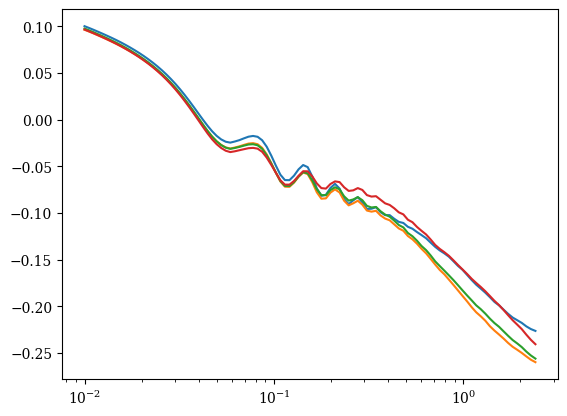

In [ ]:
plt.plot(k, X_fR);
plt.xscale('log');

### Classify your spectra and compute confidence
 (for Bayesian networks only)

In [ ]:
res_fR = get_all_probas(X_fR,
                        model_5,
                        n_classes=5,
                        num_monte_carlo=5,
                        th_prob=0.5,
                        n_samples=1000)

Computing mu and sigma...
Sigma
[[ 0.    -0.    -0.    -0.    -0.   ]
 [-0.     0.152 -0.15  -0.002 -0.   ]
 [-0.    -0.15   0.15  -0.    -0.   ]
 [-0.    -0.002 -0.     0.002 -0.   ]
 [-0.    -0.    -0.    -0.     0.   ]]
Sample probas call
U
[[ 0.301  0.    -0.    -0.     0.   ]
 [-0.     0.004 -0.    -0.     0.   ]
 [-0.     0.     0.    -0.     0.   ]
 [ 0.     0.    -0.     0.     0.   ]
 [-0.     0.    -0.    -0.     0.   ]]
Index of min eigenvalue is: 3
Min eigenvalue is: 3.7094818e-09
U has 4 elements 
Sampling...
Done.
P: [0.    0.644 0.279 0.    0.    0.077] 
P sum to 1.0
mu  sum to 0.99999994


P-non-LCDM=0.721


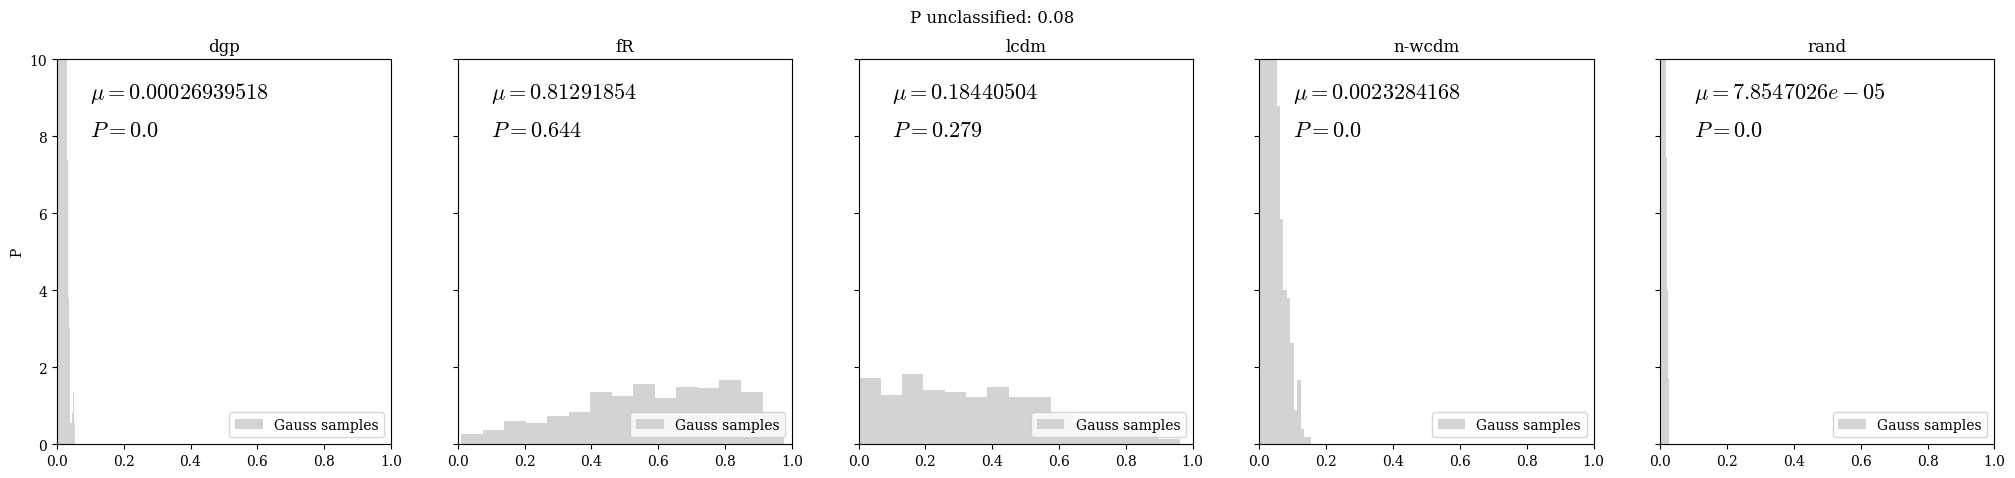

In [ ]:
print('P-non-LCDM=%s' %(np.delete(res_fR['P'], [2]).sum()))
plot_hist_1D(res_fR['samples'],
             res_fR['MM'],
             th_prob=0.5,
             P=res_fR['P'],
             inv_labels_dict=inv_labels_dict_5)
